# DSCI 100 Group 17 Report
## Predicting Whether a Pokemon is legendary

## Introduction:
In the Pokemon game, you are tasked with catching various Pokemon that inhabit the world. Legendary Pokemon are special Pokemon that are rare and powerful.

Our project's question is: **What variables can classify whether a Pokemon is legendary?** This is a **classification** problem. We will use the dataset [“The Complete Pokemon Dataset” on Kaggle.](https://www.kaggle.com/datasets/rounakbanik/pokemon) It identifies 41 different variables for each of the 801 Pokemon. The variables are: <br>
- The 6 stats used in the game
- Base Total of all Stats
- Strength/weakness against each of the 18 typings
- Number of steps to hatch an egg of the pokemon
- Base Happiness 
- Capture Rate
- Classification
- Experience Growth
- Height
- Weight
- Name
- Japanese Name
- Gender Distribution
- Pokedex Number
- First Typing
- Second Typing
- Generation
- Is Legendary


## Preliminary Exploratory Data Analysis:
Here we load the libraries, set the seed, and load the dataset from the web:

In [1]:
library(themis) # if not working, restart kernel! - may screw up other worksheets,
# tidy verse may not work!

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
set.seed(17)

pokemon_dataset <- read_csv("https://raw.githubusercontent.com/JerryMa0716/dsci-100-2023s1-group-17/main/data/pokemon.csv")

pokemon_dataset

Loading required package: recipes

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘recipes’


The following object is masked from ‘package:stats’:

    step


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ stringr 1.4.0
✔ tidyr   1.2.0     ✔ forcats 0.5.1
✔ readr   2.1.2     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ stringr::fixed() masks recipes::fixed()
✖ dplyr::lag()     masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0

abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,⋯,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
"['Overgrow', 'Chlorophyll']",1,1,1,0.5,0.5,0.5,2,2,1,⋯,88.1,1,65,65,45,grass,poison,6.9,1,0
"['Overgrow', 'Chlorophyll']",1,1,1,0.5,0.5,0.5,2,2,1,⋯,88.1,2,80,80,60,grass,poison,13.0,1,0
"['Overgrow', 'Chlorophyll']",1,1,1,0.5,0.5,0.5,2,2,1,⋯,88.1,3,122,120,80,grass,poison,100.0,1,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
['Beast Boost'],2.00,0.5,2,0.5,4.0,2.0,0.5,1.0,0.5,⋯,NA,799,97,53,43,dark,dragon,888.0,7,1
['Prism Armor'],2.00,2.0,1,1.0,1.0,0.5,1.0,1.0,2.0,⋯,NA,800,127,89,79,psychic,NA,230.0,7,1
['Soul-Heart'],0.25,0.5,0,1.0,0.5,1.0,2.0,0.5,1.0,⋯,NA,801,130,115,65,steel,fairy,80.5,7,1


<br> Next we make the data tidy. The "abilities" column has multiple values in a single cell, so we split that column up. We also do some other minor adjustments to the data. (see comments)

In [2]:
# IS_LEGENDARY IS NOW FACTOR, NOT LOGICAL

tidy_pokemon_dataset <- pokemon_dataset |>
                        mutate(abilities = substr(abilities, 2, nchar(abilities) - 1)) |>                    # remove square brackets at start and end.
                        mutate(abilities = gsub("'", "", abilities)) |>                                      # remove quotation marks.
                        separate(abilities,                                                                  # split by comma.
                                 c("ability1", "ability2", "ability3", "ability4", "ability5", "ability6"),  # (some rows have up to 6 abilities in a cell.)
                                 sep = ",") |>
                        mutate(is_legendary = as_factor(is_legendary)) |>                                    
                        mutate(capture_rate = ifelse(row_number() == 774, "30", capture_rate)) |>            # Row 774 is the only pokemon with 2 forms and different
                        mutate(capture_rate = as.numeric(capture_rate))                                      # catch rates per form. We choose the most common form's catch rate.

tidy_pokemon_dataset

Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 788 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, ...].”


ability1,ability2,ability3,ability4,ability5,ability6,against_bug,against_dark,against_dragon,against_electric,⋯,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<fct>
Overgrow,Chlorophyll,NA,NA,NA,NA,1,1,1,0.5,⋯,88.1,1,65,65,45,grass,poison,6.9,1,0
Overgrow,Chlorophyll,NA,NA,NA,NA,1,1,1,0.5,⋯,88.1,2,80,80,60,grass,poison,13.0,1,0
Overgrow,Chlorophyll,NA,NA,NA,NA,1,1,1,0.5,⋯,88.1,3,122,120,80,grass,poison,100.0,1,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Beast Boost,NA,NA,NA,NA,NA,2.00,0.5,2,0.5,⋯,NA,799,97,53,43,dark,dragon,888.0,7,1
Prism Armor,NA,NA,NA,NA,NA,2.00,2.0,1,1.0,⋯,NA,800,127,89,79,psychic,NA,230.0,7,1
Soul-Heart,NA,NA,NA,NA,NA,0.25,0.5,0,1.0,⋯,NA,801,130,115,65,steel,fairy,80.5,7,1


<br> Based on the tables and plots below, we choose height, weight, experience growth, capture rate, and total base stats to be our 5 predictor variables. This is because they are very different between legendary and non-legendary pokemon. For an example, look at the scatterplots and histograms below.

is_legendary,weight_kg,height_m,experience_growth,capture_rate,base_total
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,6.9,0.7,1059860,45,318
0,13.0,1.0,1059860,45,405
0,100.0,2.0,1059860,45,625
⋮,⋮,⋮,⋮,⋮,⋮
1,888.0,5.5,1250000,15,570
1,230.0,2.4,1250000,3,600
1,80.5,1.0,1250000,3,600


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



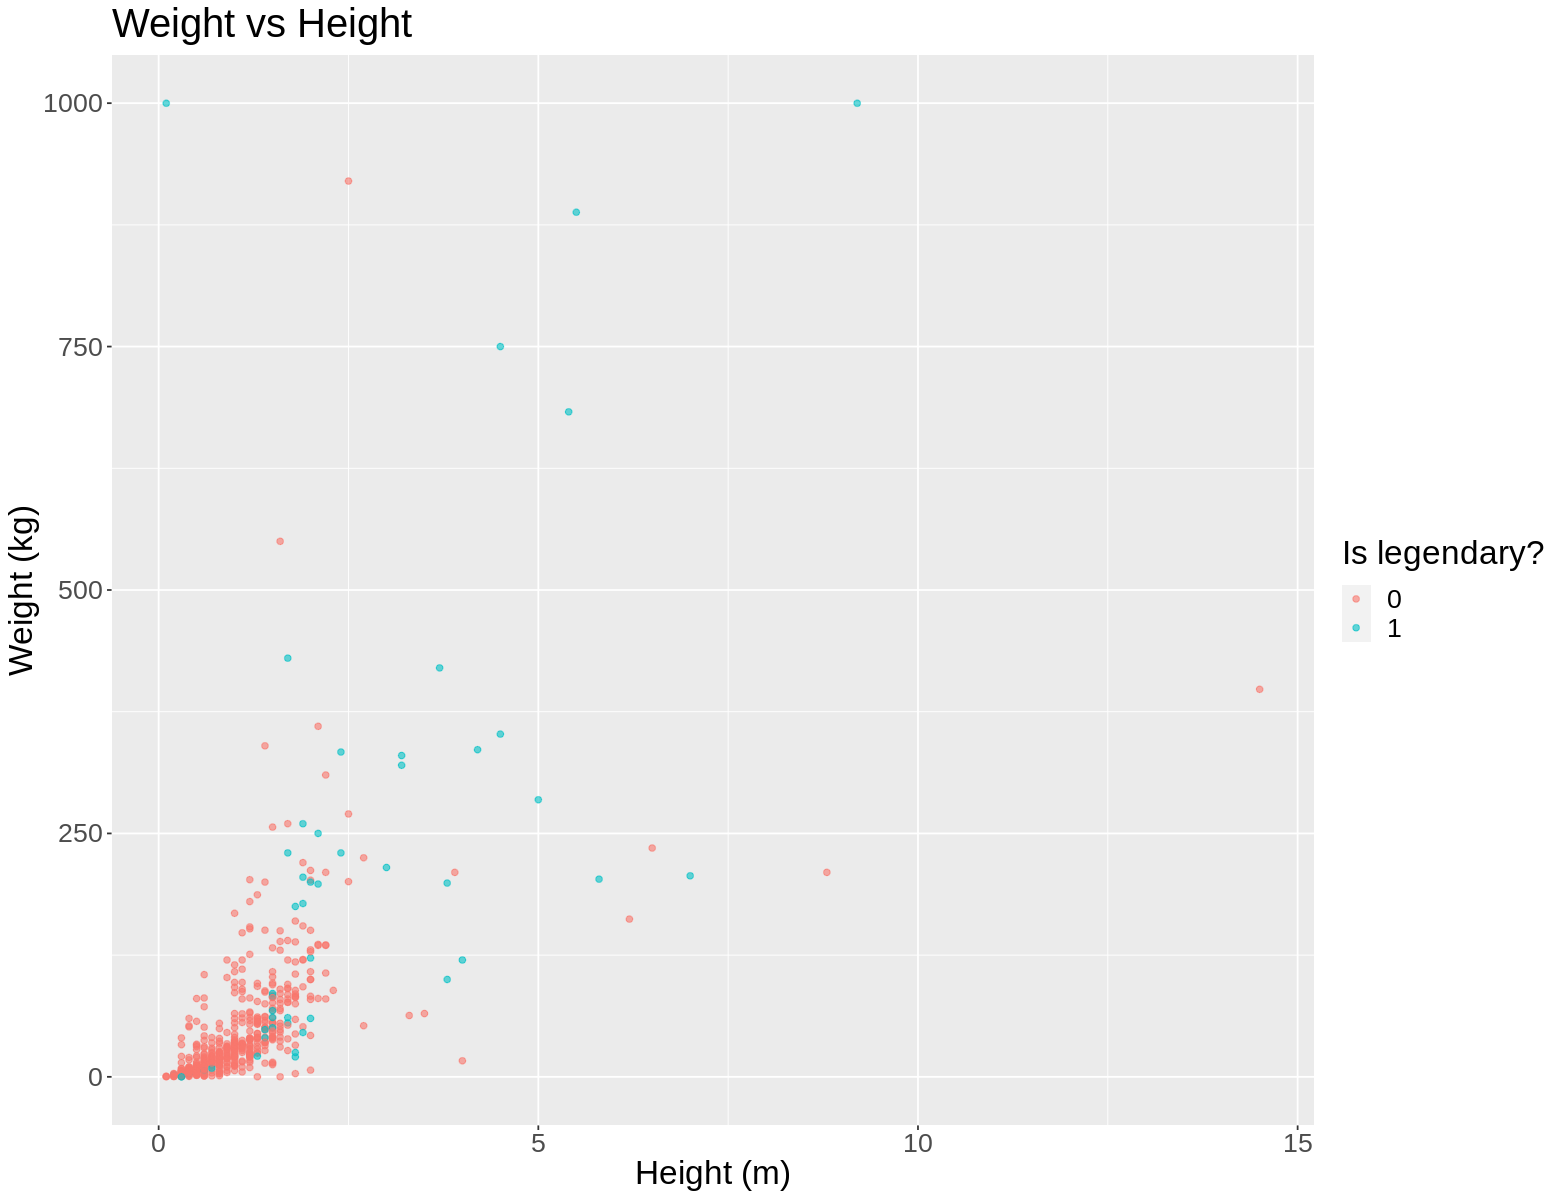

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



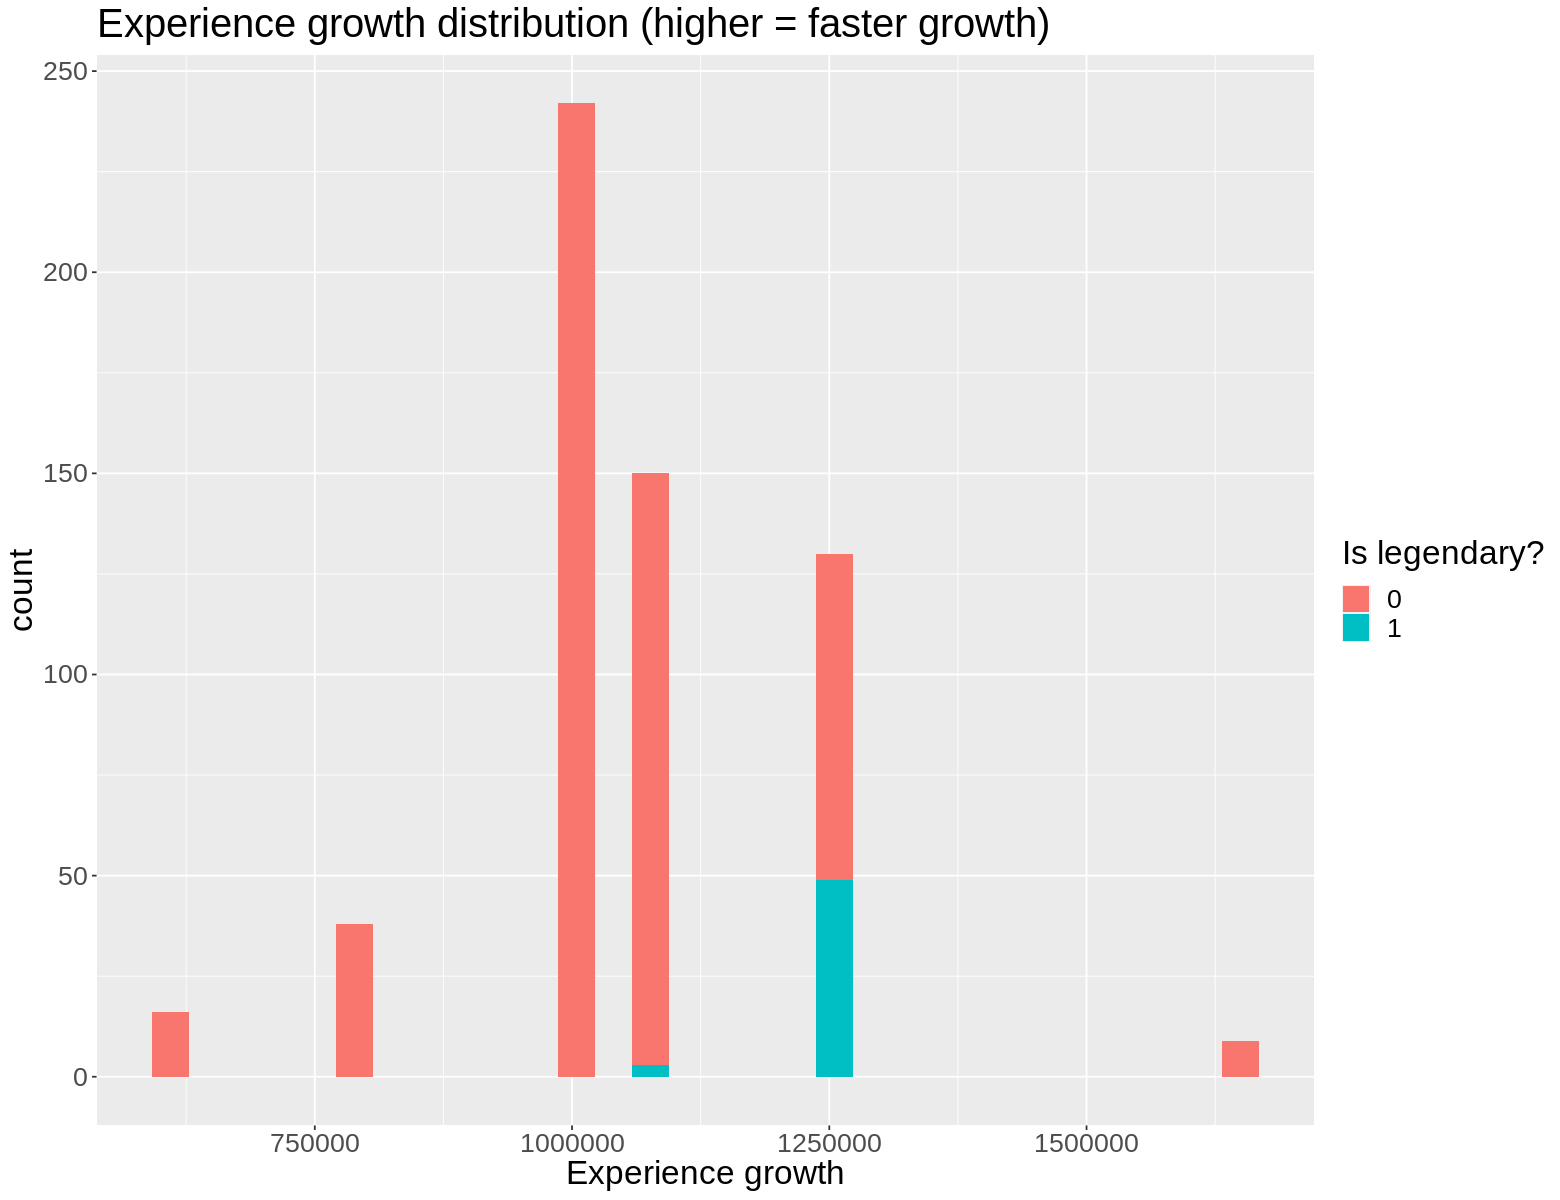

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



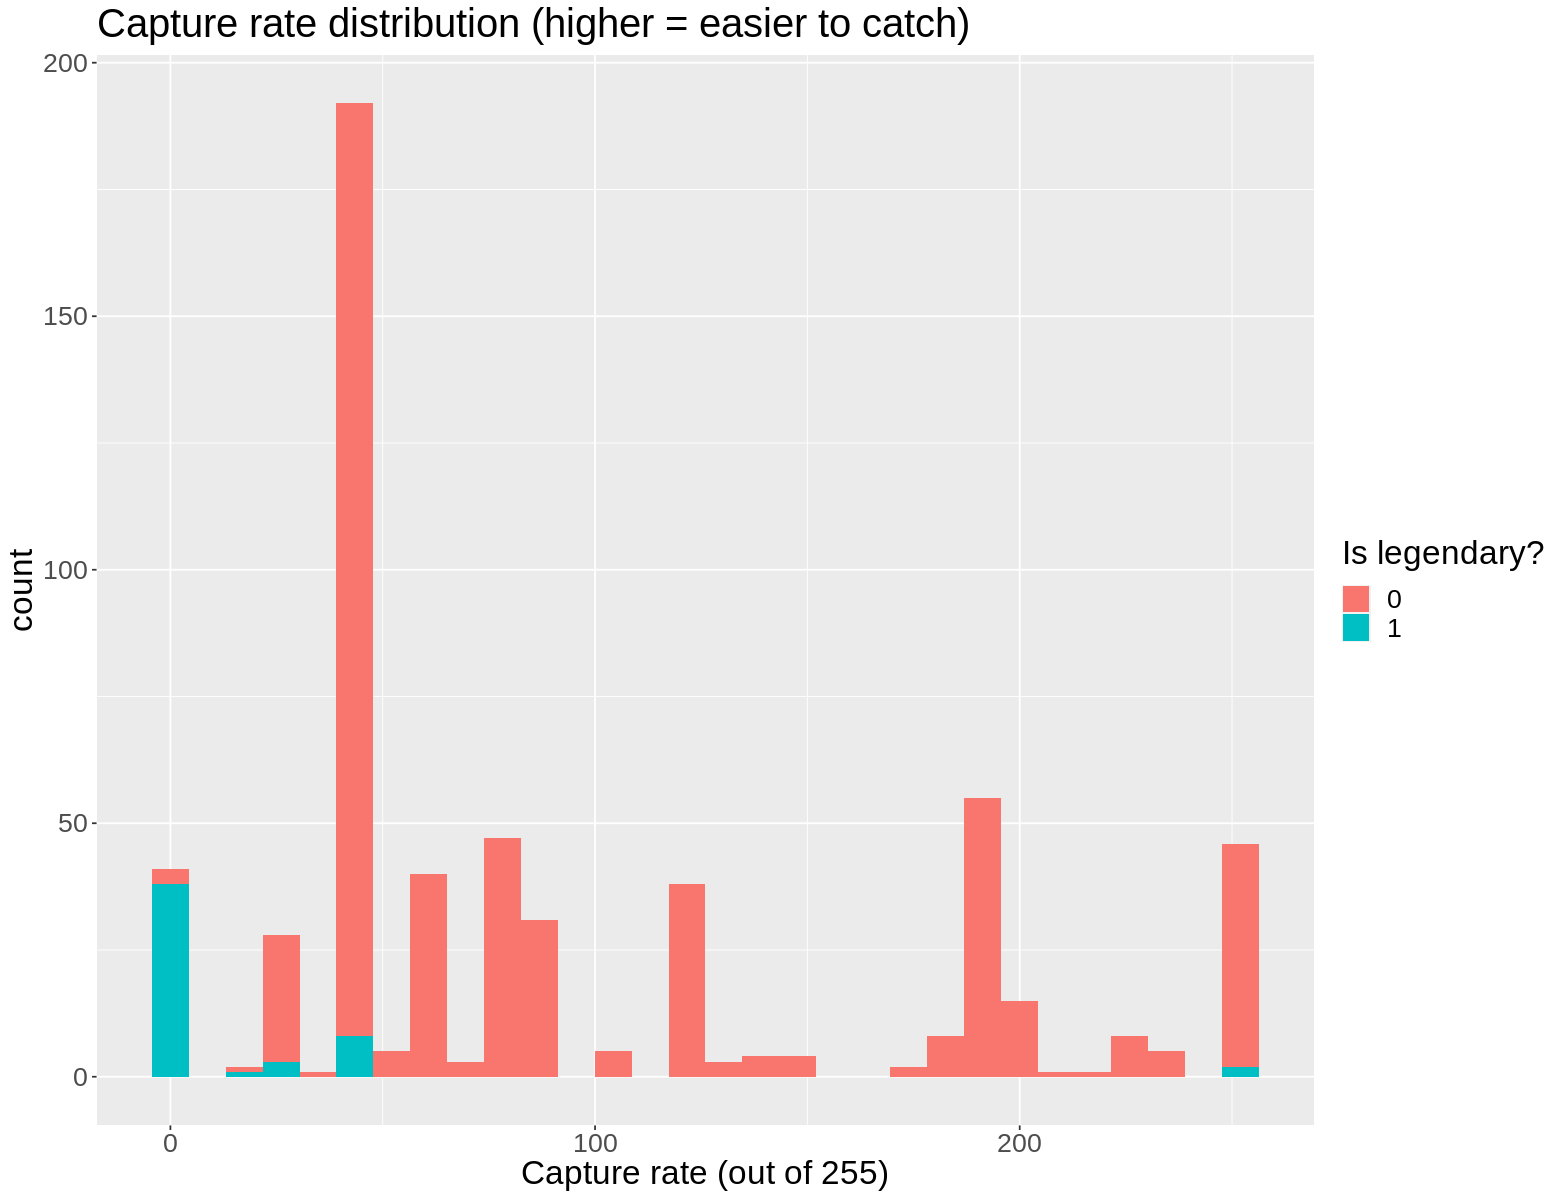

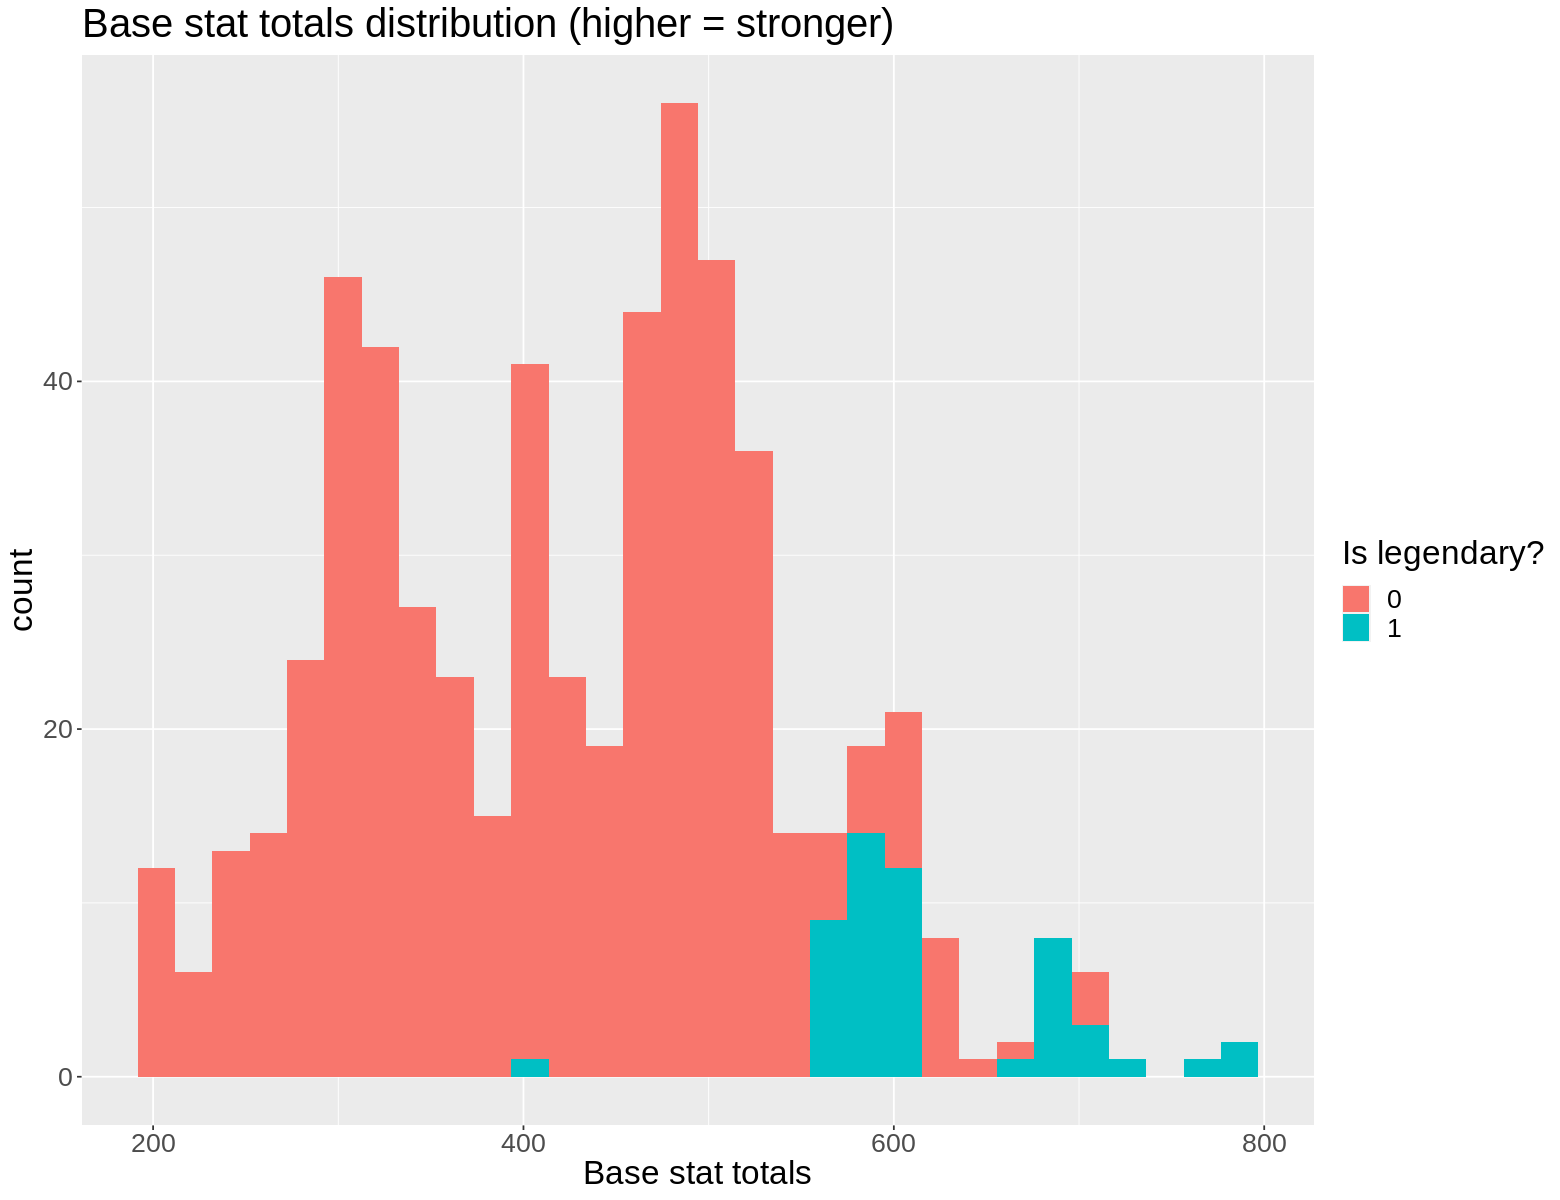

In [3]:
# try to remove NA here!
no_NA_tidy_pokemon_dataset <- select(tidy_pokemon_dataset, is_legendary, weight_kg, height_m, experience_growth, capture_rate, base_total) |>
                                na.omit()

no_NA_tidy_pokemon_dataset


pokemon_split <- initial_split(no_NA_tidy_pokemon_dataset, prop = 0.75, strata = is_legendary)
pokemon_train <- training(pokemon_split)
pokemon_test <- testing(pokemon_split)


options(repr.plot.width = 13, repr.plot.height = 10) 

# included alpha value due to overplotting
pokemon_plot_height_weight <- ggplot(pokemon_train, aes(x = height_m, y = weight_kg, color = is_legendary)) +
                geom_point(alpha = 0.6) +
                theme(text = element_text(size = 20)) +
                labs(x = "Height (m)", y = "Weight (kg)", color = "Is legendary?") +
                ggtitle("Weight vs Height")

pokemon_plot_experience_growth <- ggplot(pokemon_train, aes(x = experience_growth, fill = is_legendary)) +
                geom_histogram() +
                theme(text = element_text(size = 20)) +
                labs(x = "Experience growth", fill = "Is legendary?") +
                ggtitle("Experience growth distribution (higher = faster growth)")

pokemon_plot_capture_rate <- ggplot(pokemon_train, aes(x = capture_rate, fill = is_legendary)) +
                geom_histogram() +
                theme(text = element_text(size = 20)) +
                labs(x = "Capture rate (out of 255)", fill = "Is legendary?") +
                ggtitle("Capture rate distribution (higher = easier to catch)")

pokemon_plot_base_stats <- ggplot(pokemon_train, aes(x = base_total, fill = is_legendary)) +
                geom_histogram() +
                theme(text = element_text(size = 20)) +
                labs(x = "Base stat totals", fill = "Is legendary?") +
                ggtitle("Base stat totals distribution (higher = stronger)")


pokemon_plot_height_weight
pokemon_plot_experience_growth
pokemon_plot_capture_rate
pokemon_plot_base_stats

<br> We can see that legendary pokemon tend to be taller, heavier, have higher experience growth, lower capture rate, and higher base stat totals. Below, the tables show averages of the predictor variables for both legendaries and non-legendaries. These averages are clearly different for legendaries and non-legendaries. We also show the number of rows missing data for each predictor variable.

In [4]:
num_legendaries <- pokemon_train |>
                    group_by(is_legendary) |>
                    summarize(count = n())

weight_mean <- pokemon_train |>
                    group_by(is_legendary) |>
                    summarize(avg_weight = mean(weight_kg, na.rm = TRUE))

height_mean <- pokemon_train |>
                    group_by(is_legendary) |>
                    summarize(avg_height = mean(height_m, na.rm = TRUE))
base_total_mean <- pokemon_train |>
                    group_by(is_legendary) |>
                    summarize(avg_base_total = mean(base_total, na.rm = TRUE))

exp_mean <- pokemon_train |>
                    group_by(is_legendary) |>
                    summarize(avg_experience_growth = mean(experience_growth, na.rm = TRUE))

capture_mean <- pokemon_train |>
                    group_by(is_legendary) |>
                    summarize(avg_capture_rate = mean(capture_rate, na.rm = TRUE))

num_NA_height <- sum(is.na(pokemon_train$height_m))
num_NA_weight <- sum(is.na(pokemon_train$weight_kg))
num_NA_base_total <- sum(is.na(pokemon_train$base_total))
num_NA_capture_rate <- sum(is.na(pokemon_train$capture_rate))
num_NA_experience_growth <- sum(is.na(pokemon_train$experience_growth))

num_NA_vec <- c("missing height rows" = num_NA_height,
                "missing weight rows" = num_NA_weight,
                "missing base total rows" = num_NA_base_total,
                "missing capture rate rows" = num_NA_capture_rate,
                "missing experience growth rows" = num_NA_experience_growth)

num_NA_table <- bind_rows(num_NA_vec)
num_NA_table

summary_table <- num_legendaries |>
                    bind_cols(select(weight_mean, -is_legendary)) |>
                    bind_cols(select(height_mean, -is_legendary)) |>
                    bind_cols(select(base_total_mean, -is_legendary)) |>
                    bind_cols(select(exp_mean, -is_legendary)) |>
                    bind_cols(select(capture_mean, -is_legendary))

summary_table

missing height rows,missing weight rows,missing base total rows,missing capture rate rows,missing experience growth rows
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


is_legendary,count,avg_weight,avg_height,avg_base_total,avg_experience_growth,avg_capture_rate
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,533,46.72176,1.062477,412.0844,1039042,102.6698
1,52,211.04038,2.425000,617.6538,1239030,20.7500


## Methods:
Based on the above tables and plots, weight, height, base stat total, experience growth, and capture rate clearly tend to have different values for legendary and non-legendary pokemon and therefore will be useful for predicting, so we use them as our predictor variables. <br>

For our data analysis, we will use K-nearest neighbors to see what a new observation most closely matches with. We will center and scale all our data, because some of our predictors are on different scales of magnitude. We will use cross-validation to select the best number of neighbors(k). <br>
In addition, we plan to use a line plot to visualize the accuracies of different k values, and use that visualization to justify our k selection. <br>

We will then use the best k with our model to predict the testing data. We will show the accuracy with a confusion matrix. Also, for incorrect predictions from our model, we will use a scatterplot to show the "location" of the new observation and its relation to the closest data points, to visualize how/why our model predicted incorrectly.


## Expected outcomes and significance:
In this project, we expect to find predictors, like height, weight, etc, that can help us predict whether a Pokemon is legendary or non-legendary.<br>

The impact is that the findings can help predict if previously unseen Pokemon from new games are legendary or not. <br>

This project could lead to future questions like: What other characteristics of a pokemon can predict whether they are legendary (e.g. typing) ? Can these same characteristics predict whether a pokemon is mythical? (another type of rare pokemon)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9794872,5,0.005796863,Preprocessor1_Model01
2,accuracy,binary,0.9794872,5,0.005796863,Preprocessor1_Model02
3,accuracy,binary,0.9811966,5,0.006280743,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,binary,0.9555556,5,0.007352415,Preprocessor1_Model18
19,accuracy,binary,0.9572650,5,0.007150940,Preprocessor1_Model19
20,accuracy,binary,0.9572650,5,0.007150940,Preprocessor1_Model20


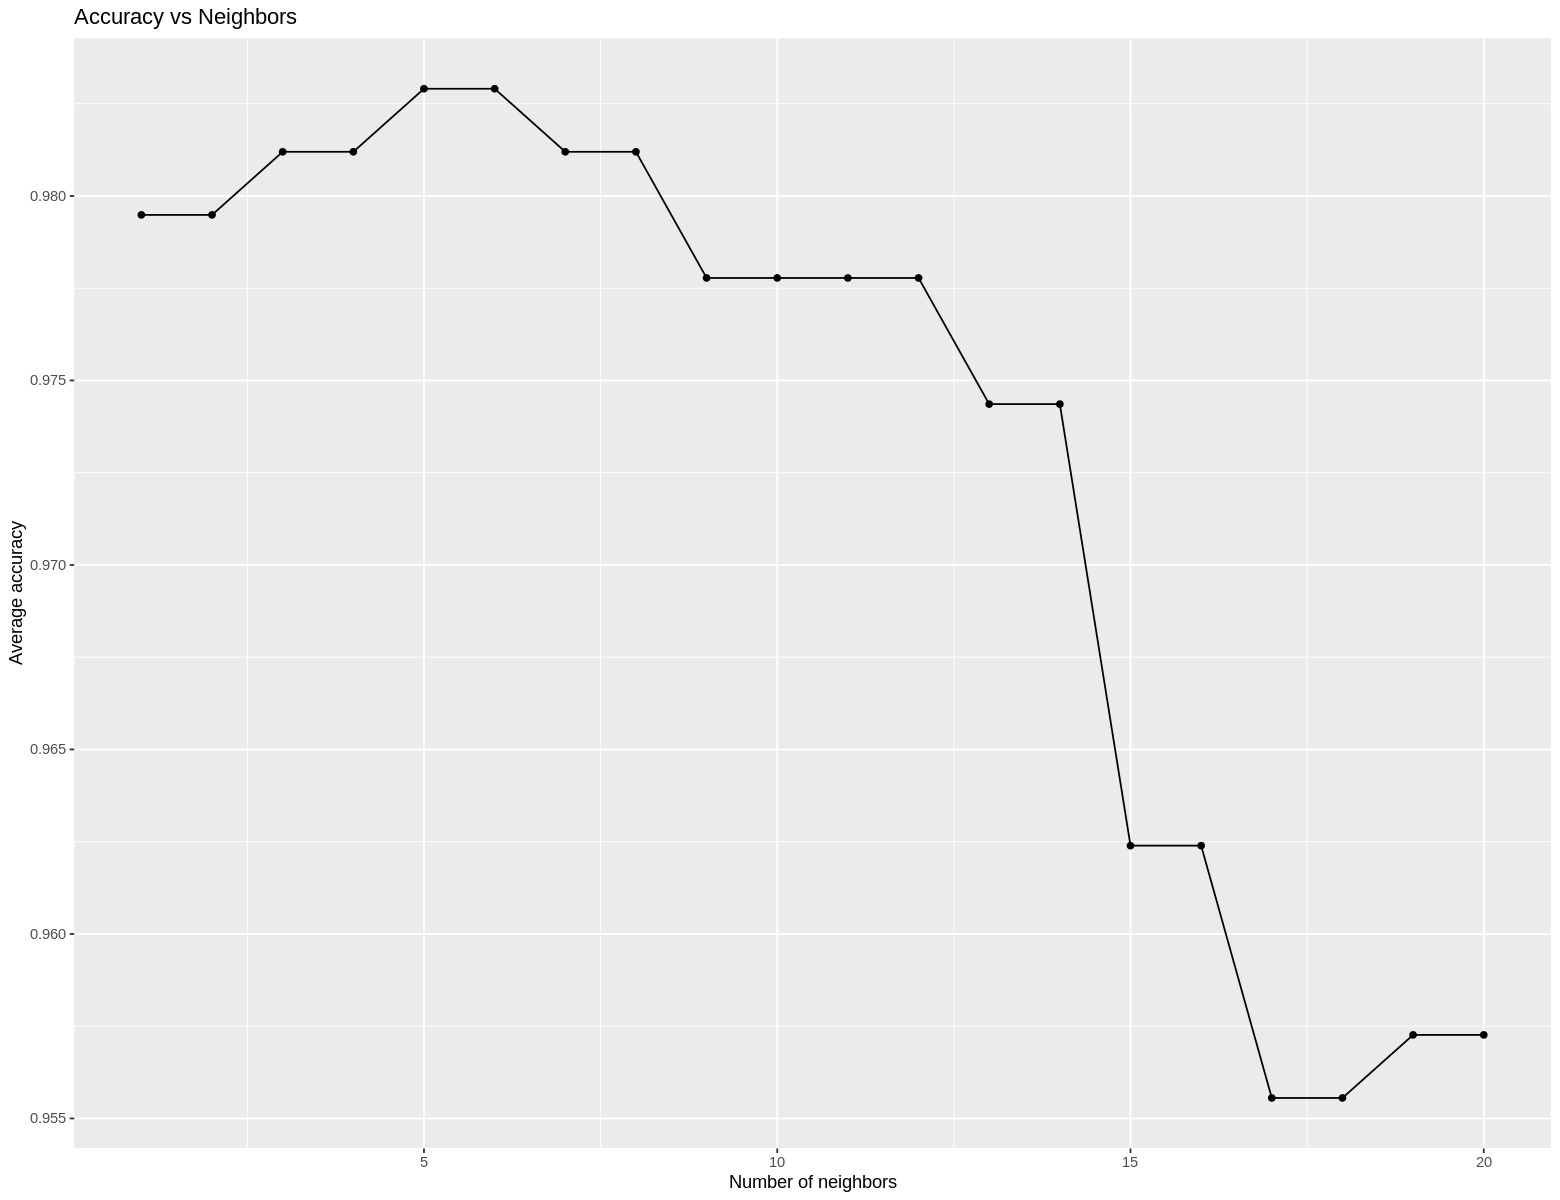

In [5]:


k_choices <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

pokemon_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                                    set_engine("kknn") |>
                                    set_mode("classification")
pokemon_recipe <- recipe(is_legendary ~ height_m + weight_kg + base_total + experience_growth + capture_rate, 
                            data = pokemon_train) |>
                                step_scale(all_predictors()) |>
                                step_center(all_predictors()) |>
                                step_upsample(is_legendary, over_ratio = 1, skip = TRUE)

pokemon_vfold <- vfold_cv(pokemon_train, v = 5, strata = is_legendary)
                            
pokemon_fit <- workflow() |>
                add_recipe(pokemon_recipe) |>
                add_model(pokemon_spec) |>
                tune_grid(resamples = pokemon_vfold, grid = k_choices)


pokemon_accuracies <- collect_metrics(pokemon_fit) |>
                        filter(.metric == "accuracy")
pokemon_accuracies


k_plot <- ggplot(pokemon_accuracies, aes(x = neighbors, y = mean)) +
            geom_point() +
            geom_line() +
            labs(x = "Number of neighbors", y = "Average accuracy") +
            ggtitle("Accuracy vs Neighbors")
k_plot


From the visualization above, choosing K = 5 results in the highest accuracy, so we will choose that for our model.

In [6]:
best_k <- 5


pokemon_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
                                    set_engine("kknn") |>
                                    set_mode("classification")

                            
pokemon_best_fit <- workflow() |>
                add_recipe(pokemon_recipe) |>
                add_model(pokemon_best_spec) |>
                fit(data = pokemon_train)


pokemon_predictions <- predict(pokemon_best_fit, pokemon_test) |>
                            bind_cols(pokemon_test)

pokemon_predictions


pokemon_test_accuracy <- pokemon_predictions |>
                            metrics(truth = is_legendary, estimate = .pred_class) |>
                            filter(.metric == "accuracy")


pokemon_test_accuracy


pokemon_test_matrix <- pokemon_predictions |>
                conf_mat(truth = is_legendary, estimate = .pred_class)

pokemon_test_matrix



.pred_class,is_legendary,weight_kg,height_m,experience_growth,capture_rate,base_total
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,8.5,0.6,1059860,45,309
0,0,19.0,1.1,1059860,45,405
0,0,9.9,0.7,1000000,120,205
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,1,230.0,3.4,1250000,45,680
0,1,55.5,1.2,1250000,45,570
1,1,80.5,1.0,1250000,3,600


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9591837


          Truth
Prediction   0   1
         0 173   2
         1   6  15

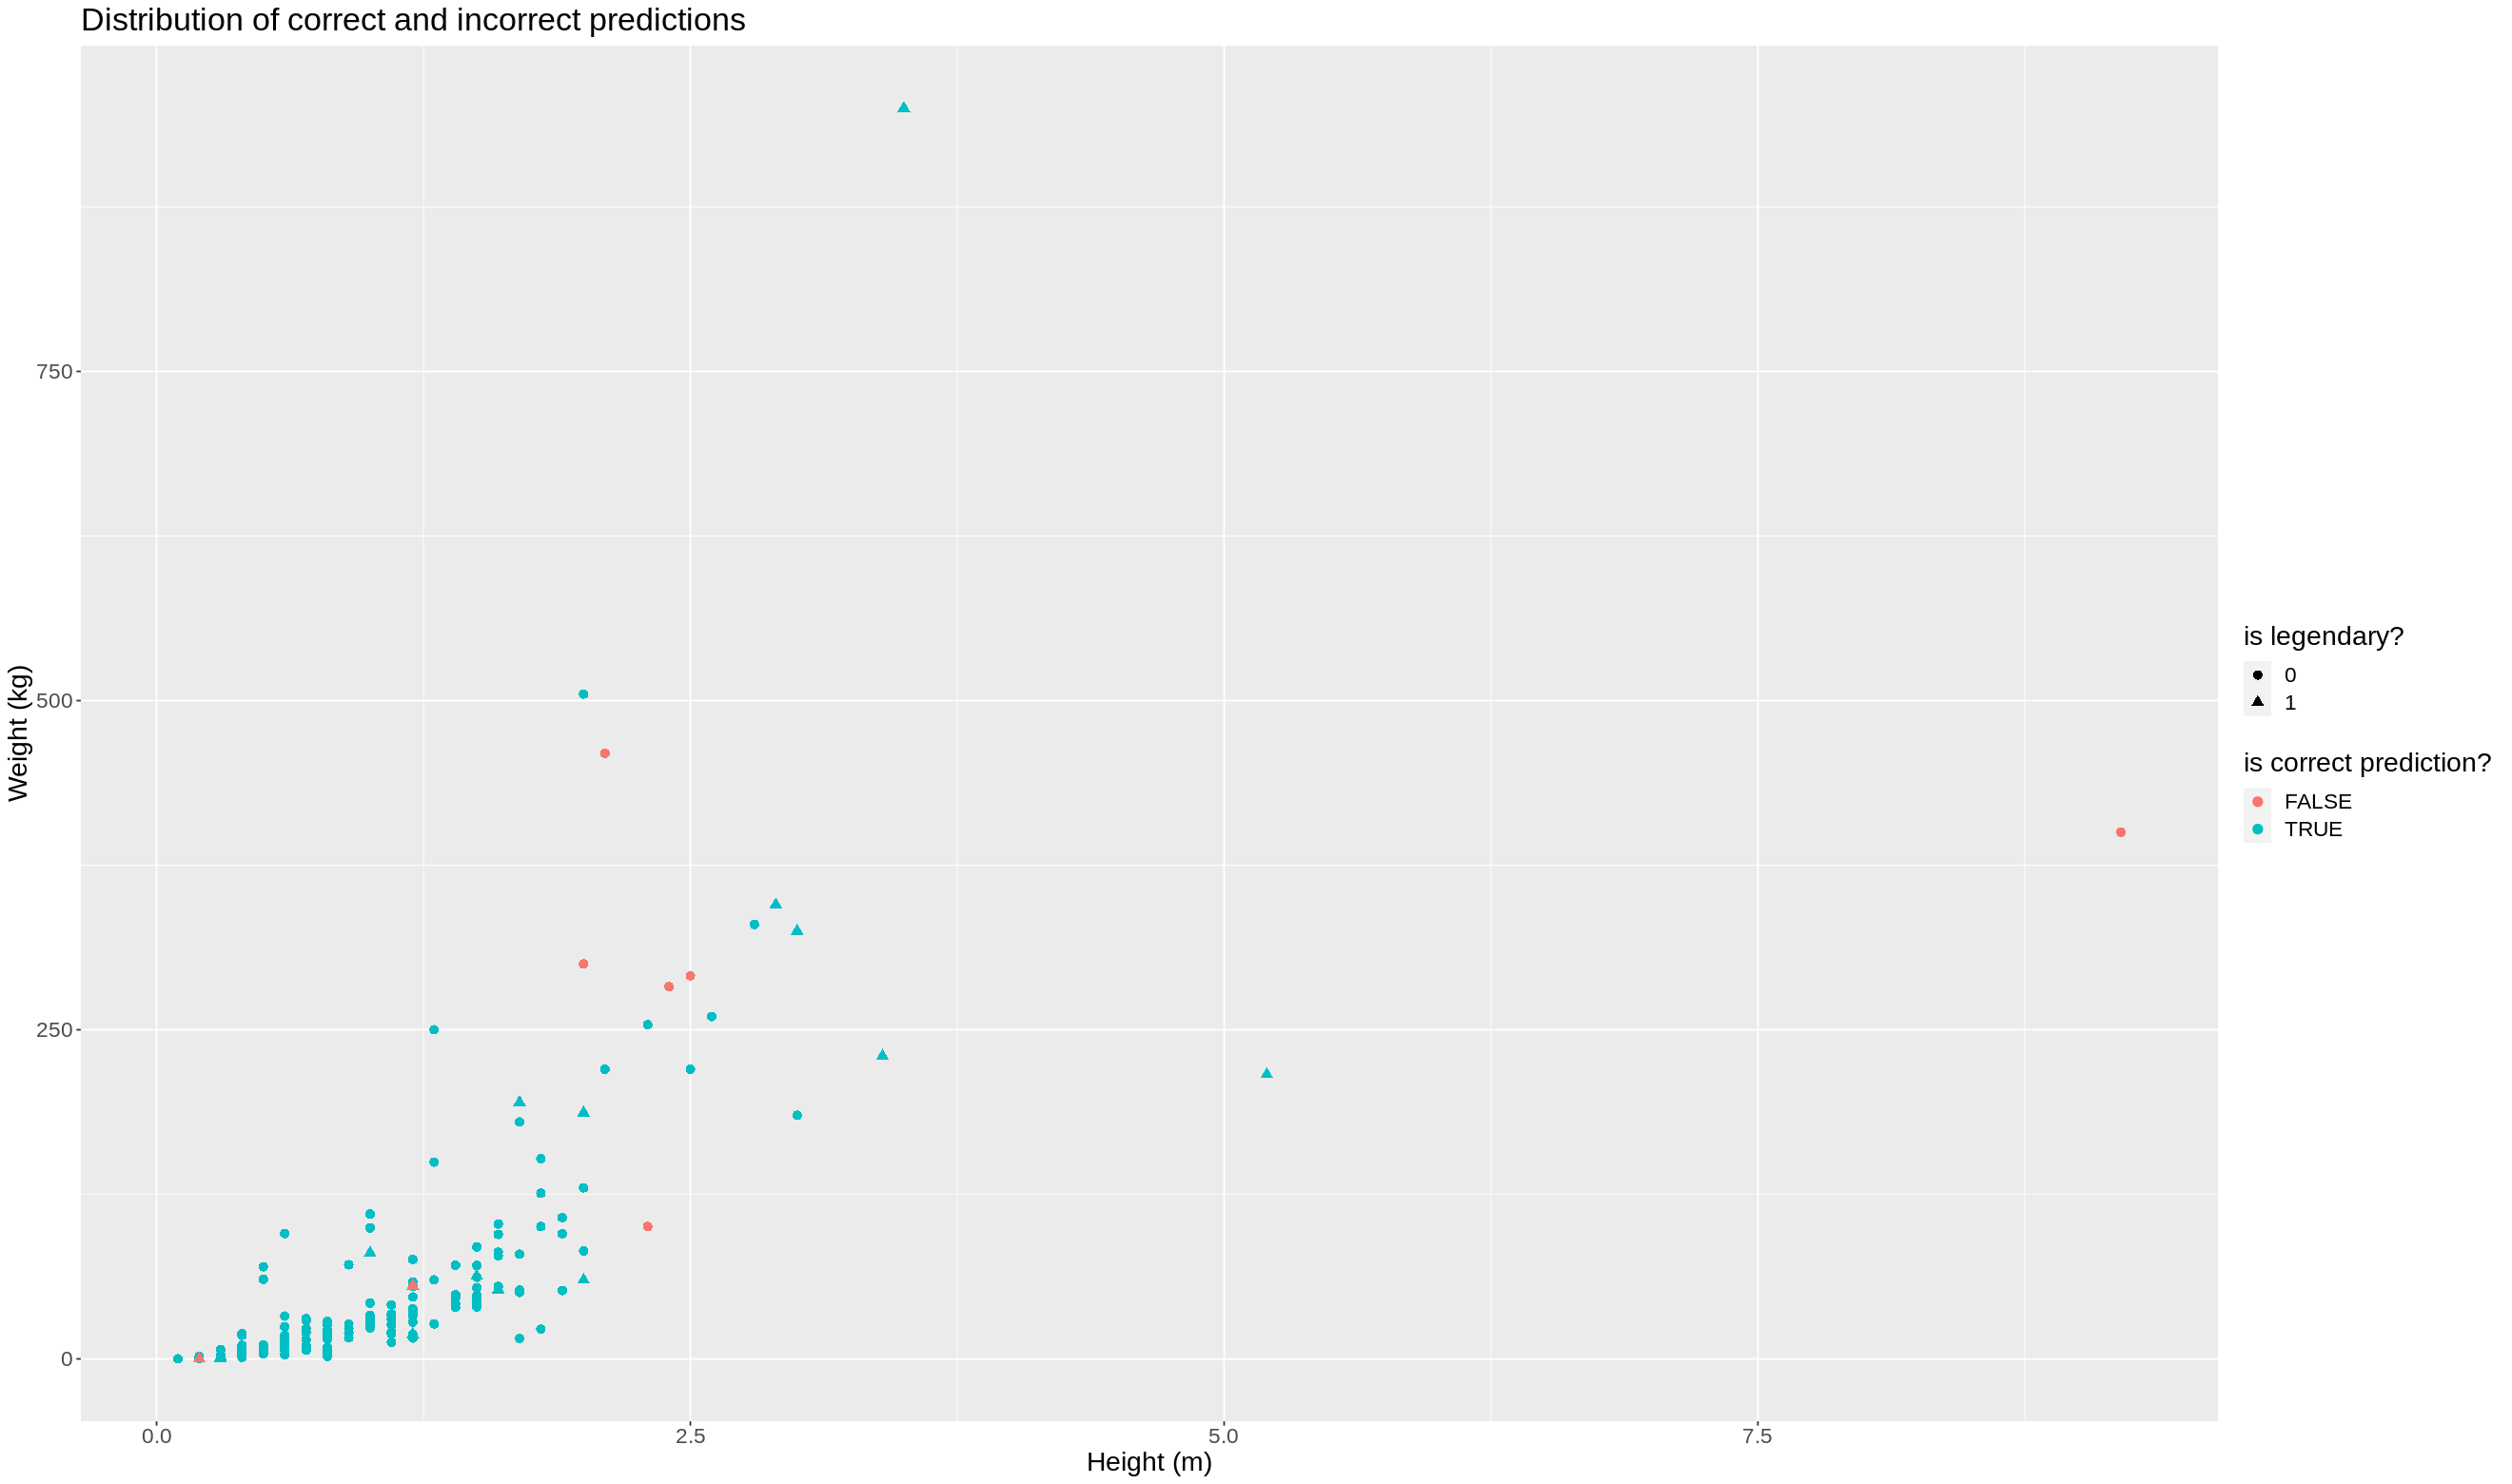

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



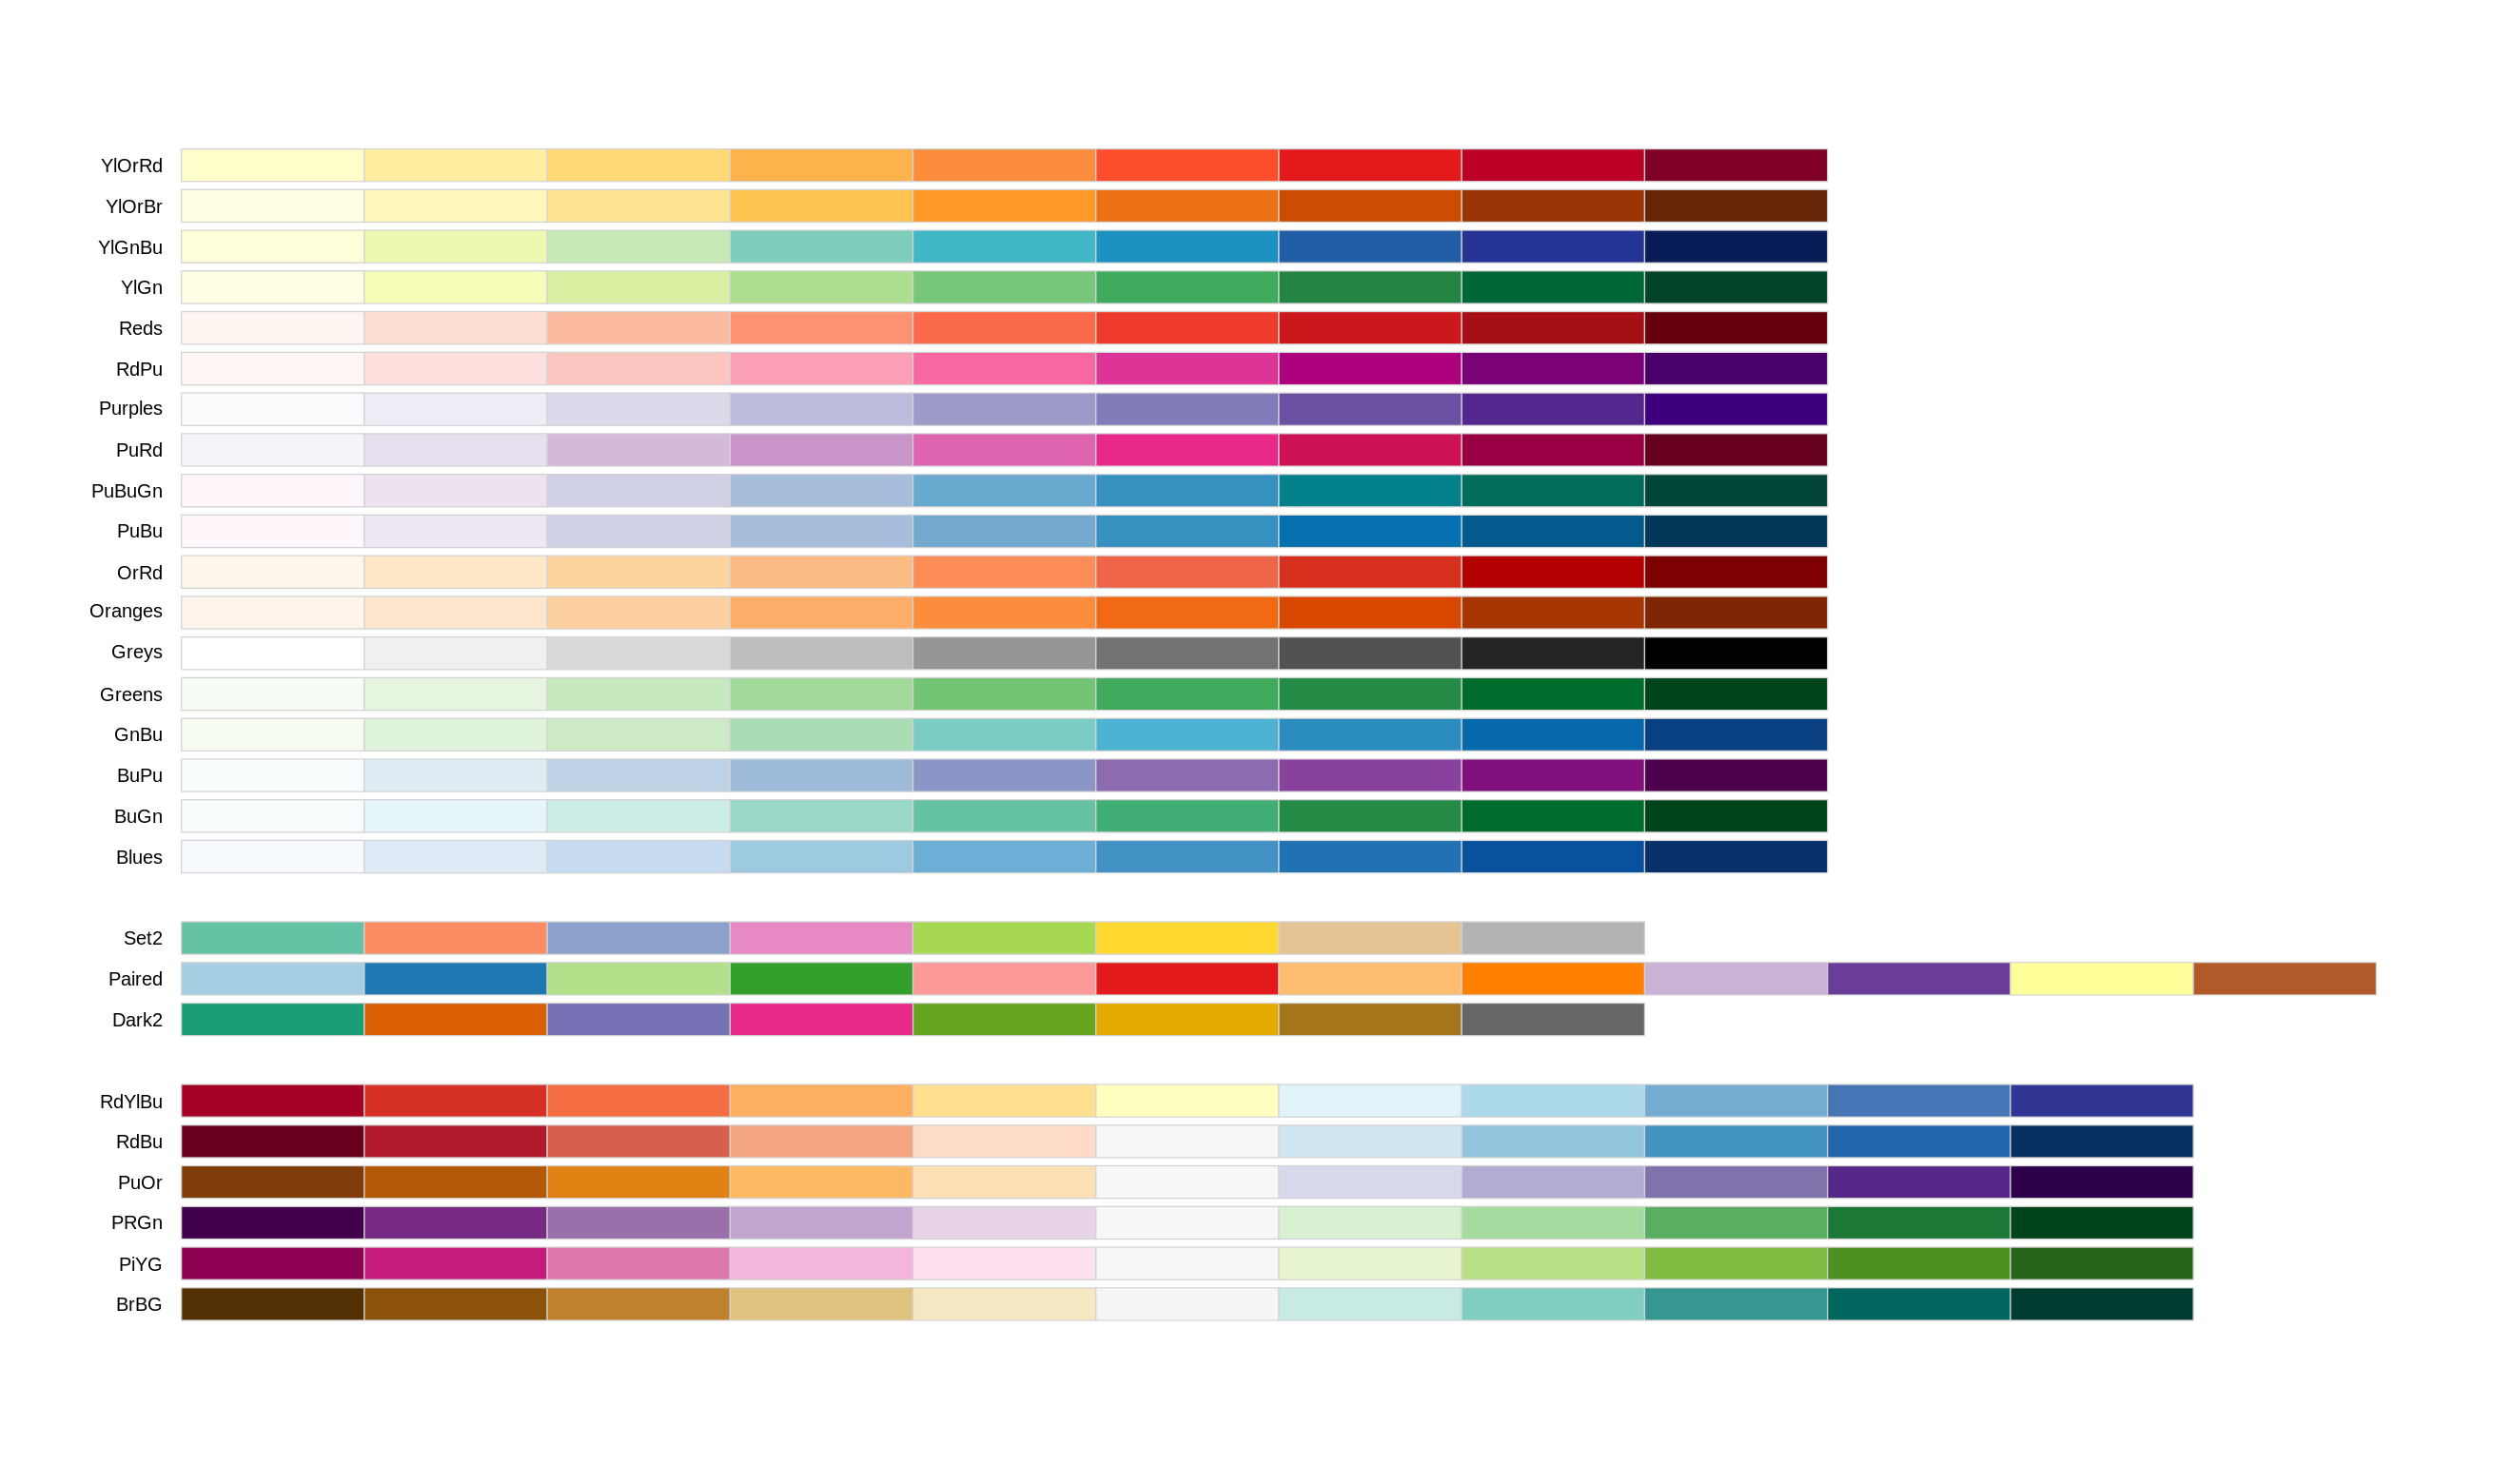

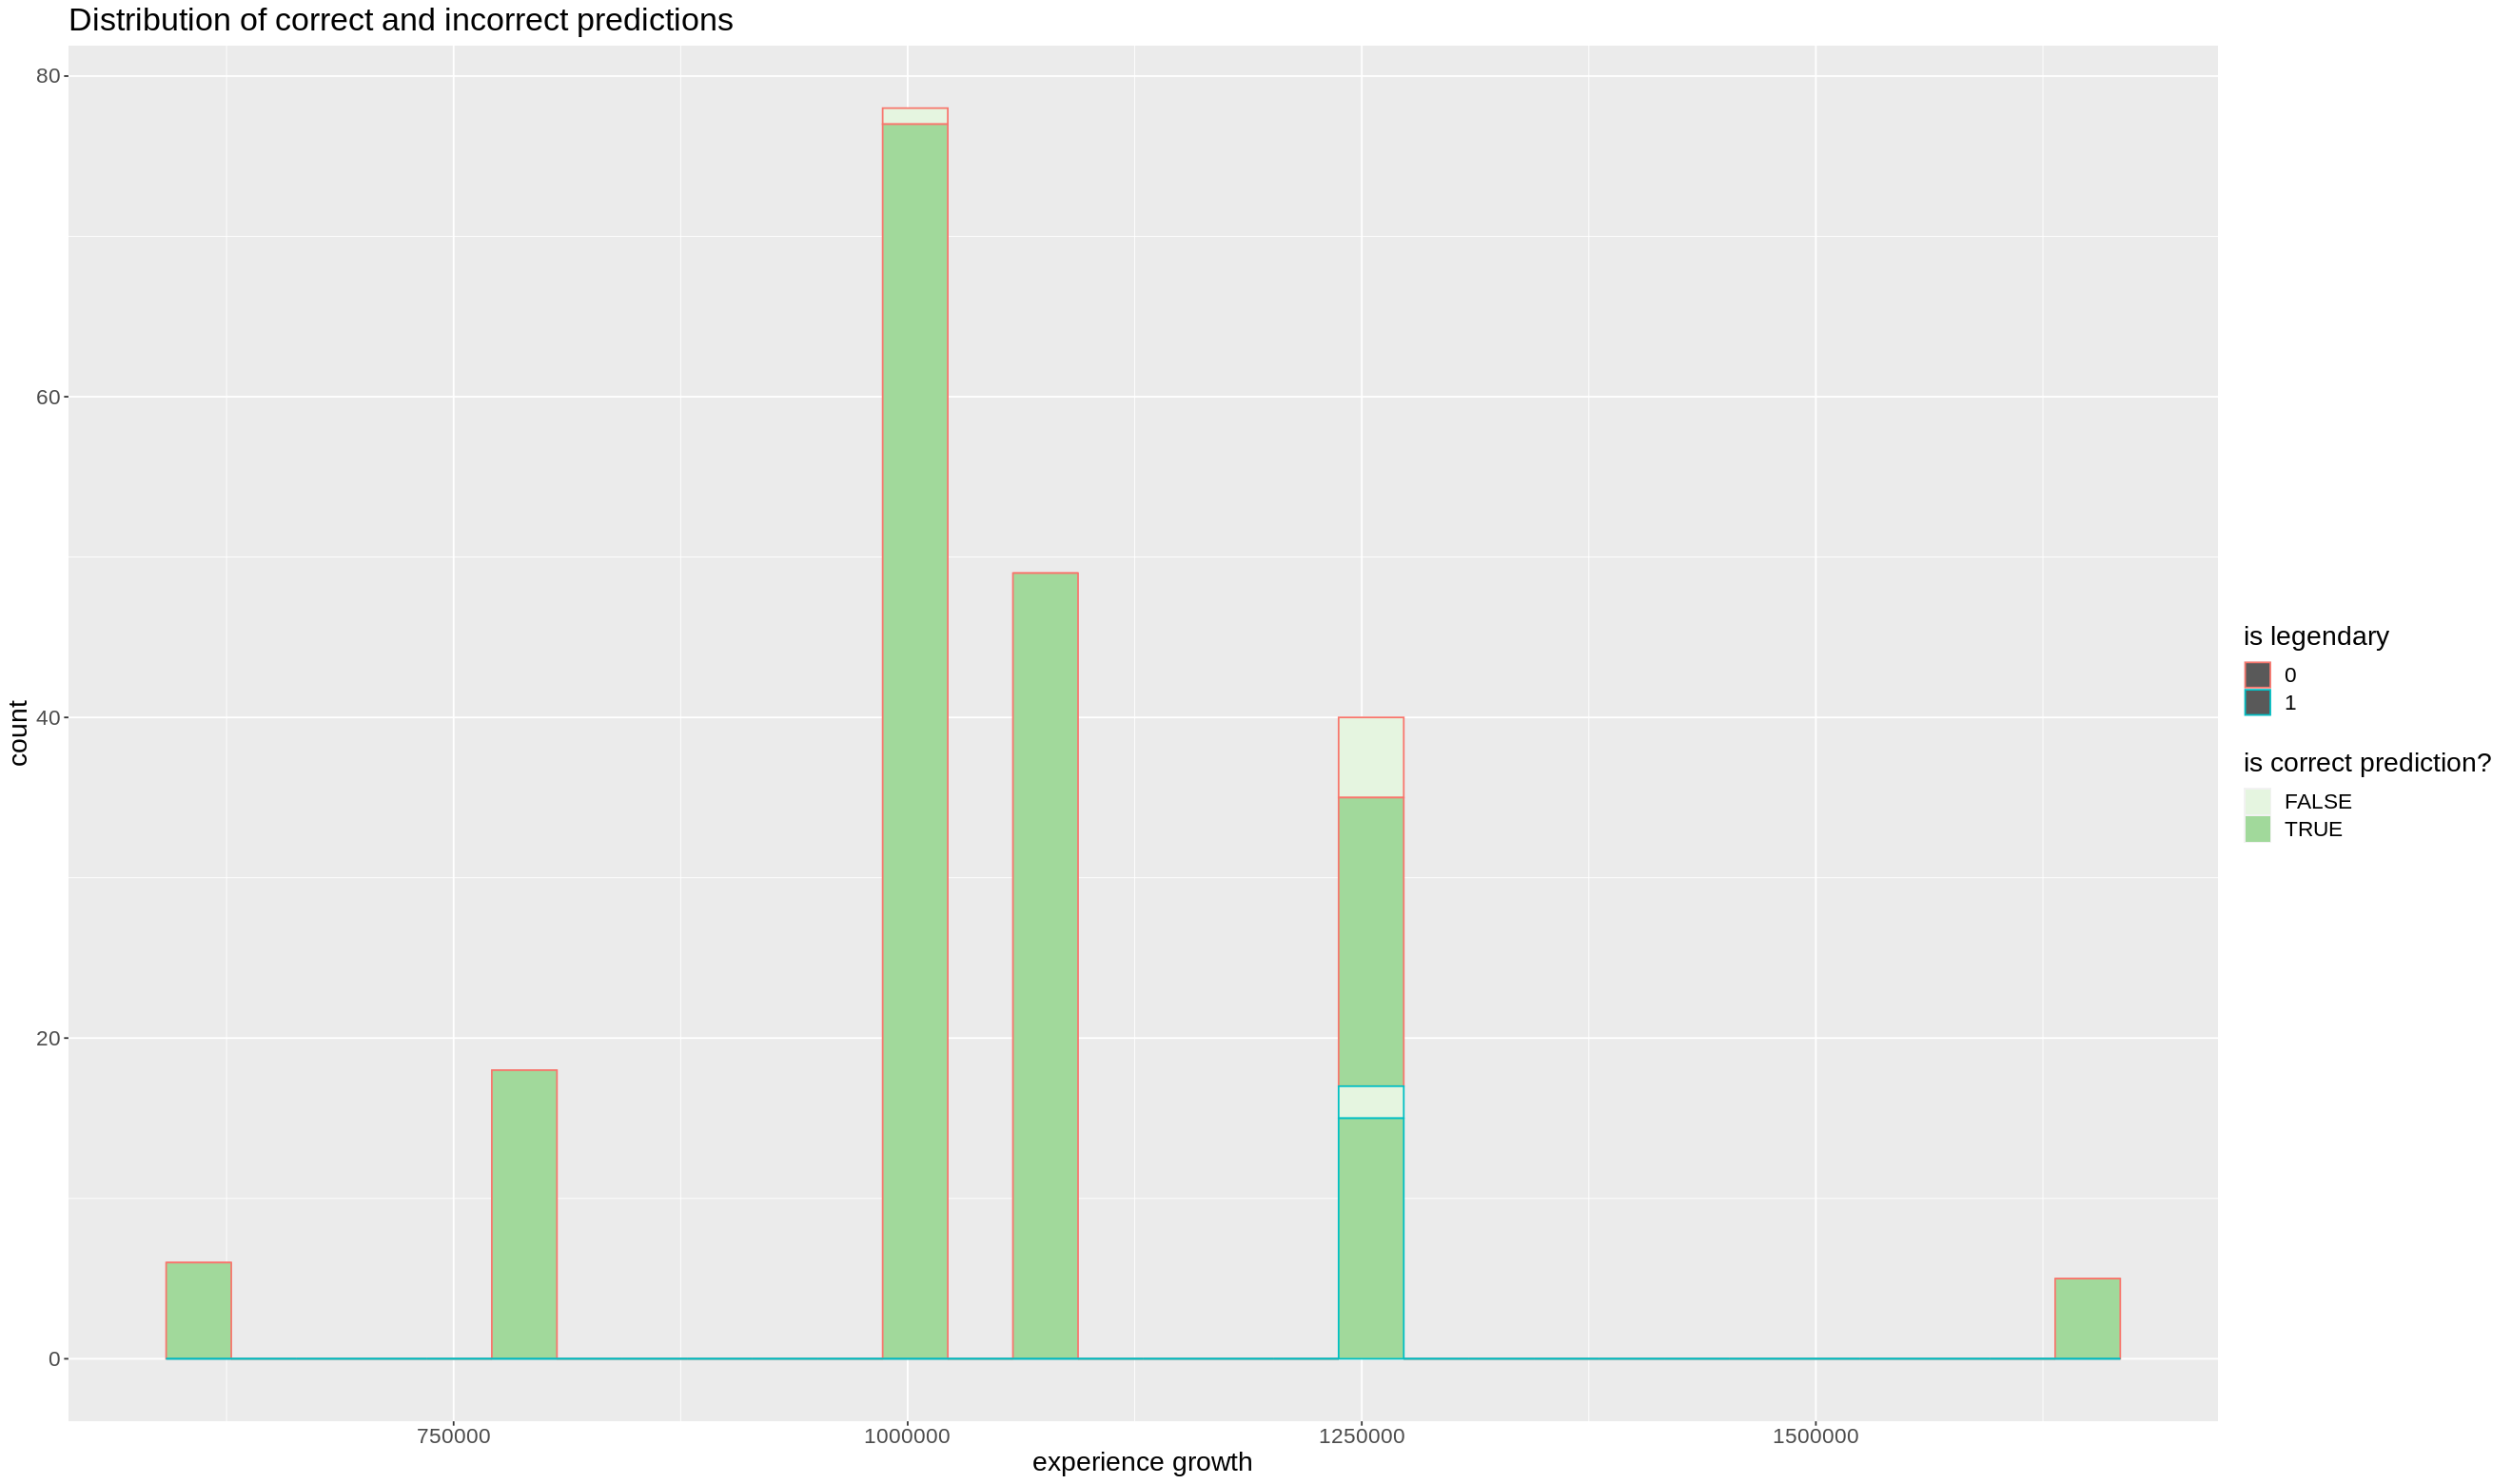

In [35]:
# visualizing which pokemon in testing set were predicted incorrectly

pokemon_correct_predictions <- pokemon_predictions |>
                                mutate(correct_prediction = (.pred_class == is_legendary))


options(repr.plot.width = 22, repr.plot.height = 13) 

pokemon_correct_predictions_height_weight_plot <- ggplot(pokemon_correct_predictions, aes(x = height_m, y = weight_kg, shape = is_legendary, color = correct_prediction)) +
                                        geom_point(size = 2.5) +
                                        labs(x = "Height (m)", y = "Weight (kg)", shape = "is legendary?", color = "is correct prediction?") +
                                        ggtitle("Distribution of correct and incorrect predictions") +
                                        theme(text = element_text(size = 17))

pokemon_correct_predictions_height_weight_plot

library(RColorBrewer)
display.brewer.all(colorblindFriendly = T)

pokemon_correct_predictions_experience_growth_plot <- ggplot(pokemon_correct_predictions, aes(x = experience_growth, color = is_legendary, fill = correct_prediction)) +
                                        geom_histogram() +
                                        labs(x = "experience growth", color = "is legendary", fill = "is correct prediction?") +
                                        ggtitle("Distribution of correct and incorrect predictions") +
                                        theme(text = element_text(size = 17)) +
                                        scale_fill_brewer(palette = "Greens")

pokemon_correct_predictions_experience_growth_plot